# Censo 2024 — Indicator exploration

Exploration of commune-level indicators from Chile's [2024 Population and Housing Census](https://censo2024.ine.gob.cl/resultados/). The data includes:

- **Electricity access** — Households with electricity (grid, solar, etc.)
- **Housing tenure** — Ownership vs renting
- **Employment by sector** — Industry/construction and transport/logistics

In [6]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Sample data processing

Sample parquet files (dwellings, households, persons) are loaded and indicators are built by commune using DuckDB. The location dictionary enriches codes with region and commune names.

The full dataset is available at: [censo2024.ine.gob.cl/resultados](https://censo2024.ine.gob.cl/resultados/). 

In [16]:
SAMPLE_DIR = "../sample"

# Read location dictionary with explicit column names (avoids CSV header/encoding issues)
loc_df = pd.read_csv(
    f"{SAMPLE_DIR}/dictionary_location.csv",
    usecols=[0, 1, 2],
    names=["codigo", "division", "nombre"],
    encoding="utf-8"
)
loc_df["nombre"] = loc_df["nombre"].str.strip()

con = duckdb.connect()

# Register the preprocessed dataframe so DuckDB can use it
con.register("loc_df", loc_df)

df = con.execute("""
WITH region_names AS (
  SELECT codigo AS region, nombre AS region_nombre FROM loc_df WHERE division = 'Región'
),
comuna_names AS (
  SELECT codigo AS comuna, nombre AS comuna_nombre FROM loc_df WHERE division = 'Comuna'
),
vivi AS (
  SELECT region, comuna,
    COUNT(*) FILTER (WHERE p9_fuente_elect IN (1,2,3,4,5)) * 100.0 / NULLIF(COUNT(*) FILTER (WHERE p9_fuente_elect IN (1,2,3,4,5,6)), 0) AS electricity_access_pct
  FROM read_parquet(?)
  WHERE tipo_operativo = 2 AND p3b_estado_ocupacion IN (1,2) AND p9_fuente_elect BETWEEN 1 AND 6
  GROUP BY region, comuna
),
hog AS (
  SELECT region, comuna,
    COUNT(*) FILTER (WHERE p12_tenencia_viv IN (1,2)) * 100.0 / NULLIF(COUNT(*), 0) AS home_ownership_pct,
    COUNT(*) FILTER (WHERE p12_tenencia_viv IN (3,4)) * 100.0 / NULLIF(COUNT(*), 0) AS renter_share_pct
  FROM read_parquet(?)
  WHERE tipo_operativo = 2 AND p12_tenencia_viv IN (1,2,3,4,5,6,7,8,9)
  GROUP BY region, comuna
),
emp AS (
  SELECT region, comuna,
    COUNT(*) FILTER (WHERE cod_caenes IN ('B','C','F')) * 100.0 / NULLIF(COUNT(*), 0) AS industry_construction_pct,
    COUNT(*) FILTER (WHERE cod_caenes = 'H') * 100.0 / NULLIF(COUNT(*), 0) AS transport_logistics_pct
  FROM read_parquet(?)
  WHERE tipo_operativo = 2 AND sit_fuerza_trabajo = 1
    AND cod_caenes IN ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U')
  GROUP BY region, comuna
),
joined AS (
  SELECT
    COALESCE(v.region, h.region, e.region) AS region,
    COALESCE(v.comuna, h.comuna, e.comuna) AS comuna,
    ROUND(v.electricity_access_pct, 2) AS electricity_access_pct,
    ROUND(h.home_ownership_pct, 2) AS home_ownership_pct,
    ROUND(h.renter_share_pct, 2) AS renter_share_pct,
    ROUND(e.industry_construction_pct, 2) AS industry_construction_pct,
    ROUND(e.transport_logistics_pct, 2) AS transport_logistics_pct
  FROM vivi v
  FULL OUTER JOIN hog h ON v.region = h.region AND v.comuna = h.comuna
  FULL OUTER JOIN emp e ON COALESCE(v.region, h.region) = e.region AND COALESCE(v.comuna, h.comuna) = e.comuna
),
with_names AS (
  SELECT j.*, rn.region_nombre, cn.comuna_nombre
  FROM joined j
  LEFT JOIN region_names rn ON j.region = rn.region
  LEFT JOIN comuna_names cn ON j.comuna = cn.comuna
)
SELECT region, comuna, region_nombre, comuna_nombre, attribute_type, attribute_value, attribute_units FROM (
  SELECT region, comuna, region_nombre, comuna_nombre, 'electricity_access' AS attribute_type, electricity_access_pct AS attribute_value, 'percent' AS attribute_units FROM with_names WHERE electricity_access_pct IS NOT NULL
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'home_ownership', home_ownership_pct, 'percent' FROM with_names WHERE home_ownership_pct IS NOT NULL
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'renter_share', renter_share_pct, 'percent' FROM with_names WHERE renter_share_pct IS NOT NULL
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'industry_construction_employment', industry_construction_pct, 'percent' FROM with_names WHERE industry_construction_pct IS NOT NULL
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'transport_logistics_employment', transport_logistics_pct, 'percent' FROM with_names WHERE transport_logistics_pct IS NOT NULL
)
ORDER BY region, comuna, attribute_type
""", [f"{SAMPLE_DIR}/viviendas_sample.parquet", f"{SAMPLE_DIR}/hogares_sample.parquet", f"{SAMPLE_DIR}/personas_sample.parquet"]).df()

df

,region,comuna,region_nombre,comuna_nombre,attribute_type,attribute_value,attribute_units
0,1,1101,Tarapacá,Iquique,electricity_access,100.00,percent
1,1,1101,Tarapacá,Iquique,home_ownership,40.00,percent
2,1,1101,Tarapacá,Iquique,industry_construction_employment,22.79,percent
3,1,1101,Tarapacá,Iquique,renter_share,43.48,percent
4,1,1101,Tarapacá,Iquique,transport_logistics_employment,7.35,percent
...,...,...,...,...,...,...,...
1591,16,16305,Ñuble,San Nicolás,electricity_access,100.00,percent
1592,16,16305,Ñuble,San Nicolás,home_ownership,83.33,percent
1593,16,16305,Ñuble,San Nicolás,industry_construction_employment,20.00,percent
1594,16,16305,Ñuble,San Nicolás,renter_share,8.33,percent


In [17]:
labels = ["very low", "low", "medium", "high", "very high"]
df["attribute_category"] = df.groupby("attribute_type")["attribute_value"].transform(
    lambda s: pd.qcut(s, 5, labels=False, duplicates="drop").map(lambda i: labels[min(i, 4)])
    if s.nunique() > 1 else "medium"
)
df.head(5)

,region,comuna,region_nombre,comuna_nombre,attribute_type,attribute_value,attribute_units,attribute_category
0,1,1101,Tarapacá,Iquique,electricity_access,100.00,percent,very low
1,1,1101,Tarapacá,Iquique,home_ownership,40.00,percent,very low
2,1,1101,Tarapacá,Iquique,industry_construction_employment,22.79,percent,high
3,1,1101,Tarapacá,Iquique,renter_share,43.48,percent,high
4,1,1101,Tarapacá,Iquique,transport_logistics_employment,7.35,percent,low


In [18]:
df.to_csv("../sample/curated_data.csv", index=False)

## 2. Curated data analysis

The `curated_data.csv` file contains aggregated results by commune (national sample). Below are the distributions for each indicator.

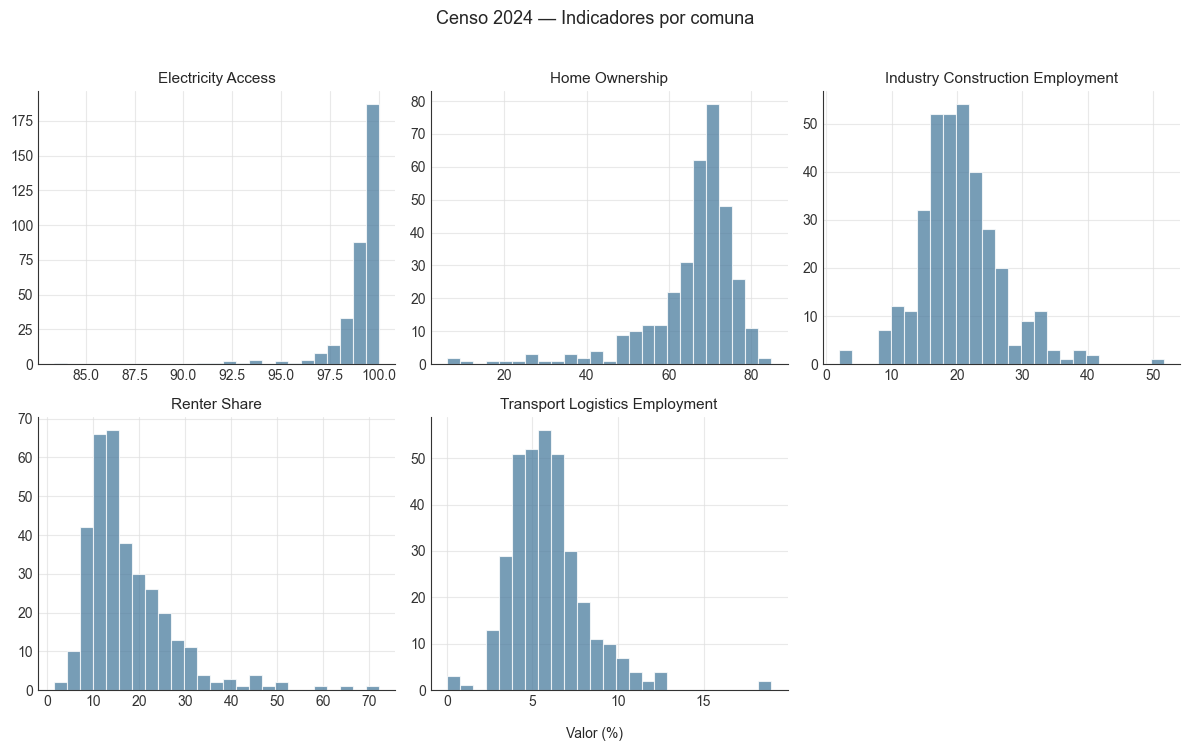

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../sample/curated_data.csv")

# Minimal style
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#e0e0e0",
    "grid.alpha": 0.7,
    "xtick.color": "#333",
    "ytick.color": "#333",
    "font.size": 10,
})

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

for i, attr in enumerate(df["attribute_type"].unique()):
    ax = axes[i]
    data = df.loc[df["attribute_type"] == attr, "attribute_value"]
    ax.hist(data, bins=25, color="#4a7c9e", alpha=0.75, edgecolor="white", linewidth=0.8)
    ax.set_title(attr.replace("_", " ").title(), fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].axis("off")

fig.suptitle("Censo 2024 — Indicators by commune", fontsize=13, y=1.02)
fig.text(0.5, -0.02, "Value (%)", ha="center", fontsize=10)
plt.tight_layout()
plt.show()